# Import Libraries

In [3]:
pip install rdkit mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.6/34.6 MB 14.8 MB/s eta 0:00:00


In [14]:
from google.colab import drive
import os
import numpy as np
import pandas as pd
import xgboost as xgb
from rdkit import Chem
from sklearn.preprocessing import OrdinalEncoder, label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from imblearn.over_sampling import SMOTE
import mlflow
from mlflow.tracking import MlflowClient
import matplotlib.pyplot as plt
import shap
import joblib

# Load Data

In [6]:
# load data
drive.mount('/content/drive')

# set working directory
os.chdir('/content/drive/MyDrive/Solubility')

Mounted at /content/drive


In [5]:
# define function to load datasets depending on if standardized selected or not
def load_datasets():
  X_train = pd.read_csv('X_train.csv')
  X_test = pd.read_csv('X_test.csv')
  X_valid = pd.read_csv('X_valid.csv')

  y_train = np.load('y_train_cat.npy')
  y_test = np.load('y_test_cat.npy')
  y_valid = np.load('y_valid_cat.npy')

  # print summary of datasets
  print(f"X_train shape: {X_train.shape}")
  print(f"X_test shape: {X_test.shape}")
  print(f"X_valid shape: {X_valid.shape}")
  print(f"y_train shape: {y_train.shape}")
  print(f"y_test shape: {y_test.shape}")
  print(f"y_valid shape: {y_valid.shape}")

  return X_train, X_test, X_valid, y_train, y_test, y_valid

In [6]:
X_train, X_test, X_valid, y_train, y_test, y_valid = load_datasets()

X_train shape: (6858, 34)
X_test shape: (980, 34)
X_valid shape: (1960, 34)
y_train shape: (6858,)
y_test shape: (980,)
y_valid shape: (1960,)


# Models

### Logistic Regression

In [ ]:
# setup MLflow experiment
EXPERIMENT_NAME = 'logreg_classification_descriptors_grid_search_3_classes'
mlflow.set_experiment(EXPERIMENT_NAME)

with mlflow.start_run():
    print("Starting run...")

    # get experiment ID
    experiment_id = mlflow.active_run().info.experiment_id
    print("Experiment ID:", experiment_id)

    # log experiment name
    mlflow.log_param("experiment_name", EXPERIMENT_NAME)

    # extract and log feature names
    features = X_train.columns.tolist()
    mlflow.log_param("feature_names", features)

    # set logistic regression parameters
    model = LogisticRegression(max_iter=1000)

    # define params for gridsearch
    param_grid = {
        'C': [0.1, 1, 10],
        'penalty': ['l2'],
        'solver': ['lbfgs', 'newton-cg'],
        'multi_class': ['multinomial', 'ovr'],
        'class_weight': ['balanced']
    }

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=5,
        n_jobs=-1,
        verbose=2,
        scoring='f1_macro'
    )

    # fit model
    grid_search.fit(X_train, y_train)

    # get best model
    model = grid_search.best_estimator_

    # binarize true labels
    y_train_bin = label_binarize(y_train, classes=[0, 1, 2])
    y_valid_bin = label_binarize(y_valid, classes=[0, 1, 2])

    # get probabilities
    y_train_pred_proba = model.predict_proba(X_train)
    y_valid_pred_proba = model.predict_proba(X_valid)

    # make predictions
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)

    # log model
    mlflow.sklearn.log_model(model, f"{EXPERIMENT_NAME}")

    # calculate metrics
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_auc = roc_auc_score(y_train_bin, y_train_pred_proba, multi_class='ovr', average='macro')
    train_f1 = f1_score(y_train, y_train_pred, average='macro')

    valid_accuracy = accuracy_score(y_valid, y_valid_pred)
    valid_auc = roc_auc_score(y_valid_bin, y_valid_pred_proba, multi_class='ovr', average='macro')
    valid_f1 = f1_score(y_valid, y_valid_pred, average='macro')

    # log metrics
    mlflow.log_metric("train_accuracy", train_accuracy)
    mlflow.log_metric("train_auc", train_auc)
    mlflow.log_metric("train_f1", train_f1)
    mlflow.log_metric("valid_accuracy", valid_accuracy)
    mlflow.log_metric("valid_auc", valid_auc)
    mlflow.log_metric("valid_f1", valid_f1)

    # print metrics
    print("Train Accuracy:", train_accuracy)
    print("Train AUC:", train_auc)
    print("Train F1:", train_f1)
    print("*******************")
    print("Valid Accuracy:", valid_accuracy)
    print("Valid AUC:", valid_auc)
    print("Valid F1:", valid_f1)

    # print confusion matrix
    cm = confusion_matrix(y_valid, y_valid_pred)
    print("\nConfusion Matrix:")
    print(cm)

    # print classification report
    cr = classification_report(y_valid, y_valid_pred)
    print("\nClassification Report:")
    print(cr)

    # log and print best parameters
    best_params = grid_search.best_params_
    for param, value in best_params.items():
        print(f"{param}: {value}")
        mlflow.log_param(param, value)

    # log coefficients
    coefficients = model.coef_
    for i, coef in enumerate(coefficients):
        for name, value in zip(features, coef):
            mlflow.log_metric(f"coef_class_{i}_{name}", value)

    print("\nRun complete.")


Starting run...
Experiment ID: 667307291515873150
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_linesearch.py:312: LineSearchWarning: Rounding errors prevent the line search from converging
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/optimize.py:100: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/optimize.py:312: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star =

Train Accuracy: 0.5908428113152523
Train AUC: 0.7637731464941689
Train F1: 0.5595672125532806
*******************
Valid Accuracy: 0.5872448979591837
Valid AUC: 0.7654901637752708
Valid F1: 0.5524720448452801

Confusion Matrix:
[[475  80  14]
 [329 132 278]
 [ 65  43 544]]

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.83      0.66       569
           1       0.52      0.18      0.27       739
           2       0.65      0.83      0.73       652

    accuracy                           0.59      1960
   macro avg       0.57      0.62      0.55      1960
weighted avg       0.57      0.59      0.54      1960

C: 0.1
class_weight: balanced
multi_class: ovr
penalty: l2
solver: newton-cg

Run complete.


In [ ]:
# check coefficients
coefficients = model.coef_
for i, coef in enumerate(coefficients):
  print(f"Class {i}:")
  for name, value in zip(features, coef):
    print(f"{name}: {value}")

Class 0:
MaxEStateIndex: -2.548864298680661e-23
MinEStateIndex: 8.778428916432003e-24
qed: -2.3891947055612447e-24
SPS: 5.787317820827059e-23
MolWt: 6.773717442411076e-21
MaxPartialCharge: -1.4214643853702243e-24
MinPartialCharge: 2.2948899964192298e-24
FpDensityMorgan2: -2.0593085466858026e-23
BCUT2D_MWHI: 1.938346705421706e-22
BCUT2D_CHGHI: 4.9937870773392175e-24
BCUT2D_LOGPHI: 1.026644900896097e-23
BCUT2D_MRHI: 7.280402056513238e-24
AvgIpc: 2.0676934442612823e-23
BalabanJ: -2.6335670092551218e-23
HallKierAlpha: -1.8708496058379653e-23
Ipc: 1.8382827203101745e-13
Kappa3: -7.510879710153171e-23
TPSA: -8.114582727449104e-22
FractionCSP3: -4.883046425389331e-24
NumAmideBonds: -6.19452230809033e-24
NumAromaticCarbocycles: 4.9741143471365753e-23
NumAromaticRings: 4.7329093101794584e-23
NumAtomStereoCenters: 1.1861924337290568e-23
NumBridgeheadAtoms: -2.3212110465204826e-25
NumHAcceptors: -1.0830762967979824e-23
NumHDonors: -3.520044425591628e-23
NumHeteroatoms: 2.954435855448336e-23
NumHe

## Random Forest Classifier

In [7]:
# remove features with < 0.1 feature importance from random forest validation
for df in [X_train, X_valid, X_test]:
  df.drop(columns=[
    'NumHeterocycles',
    'NumAtomStereoCenters',
    'NumAmideBonds',
    'NumUnspecifiedAtomStereoCenters',
    'NumBridgeheadAtoms',
    'NumSpiroAtoms'
], inplace=True)

Starting run...
Experiment ID: 885874111063599595
Fitting 5 folds for each of 54 candidates, totalling 270 fits


2025/05/09 16:27:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Train Accuracy: 0.9995625546806649
Train AUC: 0.9999997794933472
Train F1: 0.9995662797357293
*******************
Valid Accuracy: 0.798469387755102
Valid AUC: 0.9271126004060712
Valid F1: 0.8032171939422232
Confusion Matrix:
[[478  90   1]
 [ 86 582  71]
 [ 12 135 505]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.84      0.83       569
           1       0.72      0.79      0.75       739
           2       0.88      0.77      0.82       652

    accuracy                           0.80      1960
   macro avg       0.81      0.80      0.80      1960
weighted avg       0.80      0.80      0.80      1960

max_depth: None
min_samples_leaf: 1
min_samples_split: 2
n_estimators: 200


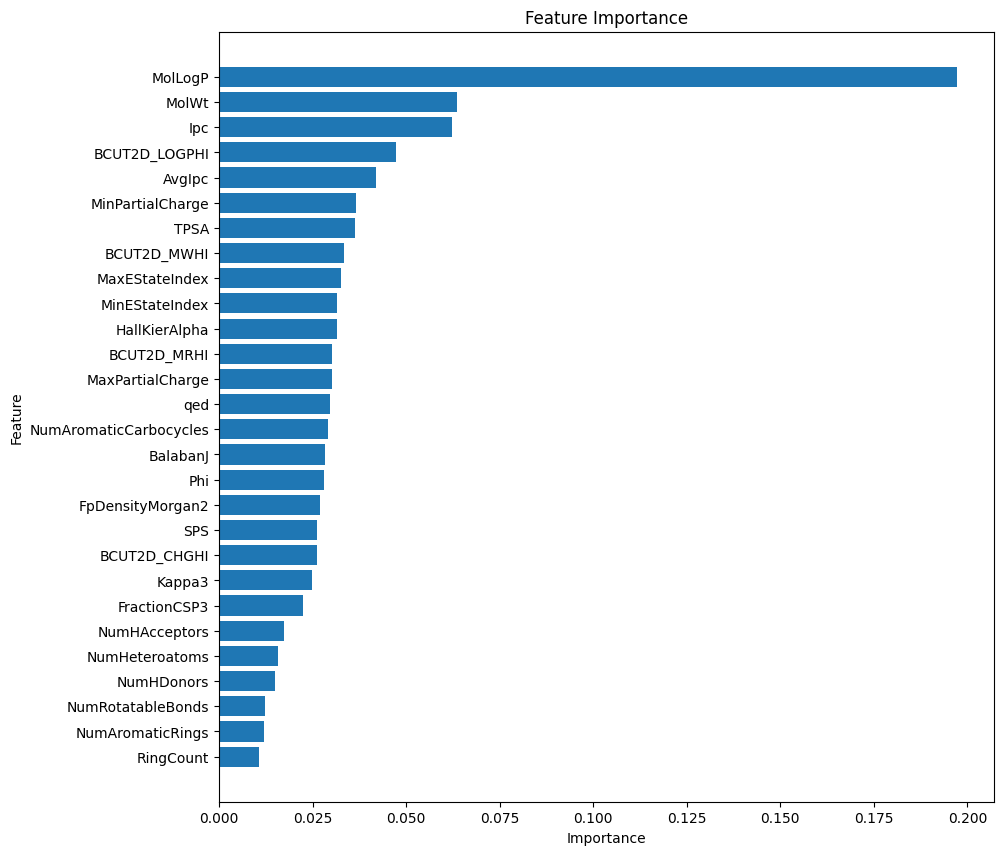

Run complete.


In [8]:
# setup MLflow experiment
EXPERIMENT_NAME = 'rf_classification_descriptors_grid_search_3_classes_final_feats'

mlflow.set_experiment(EXPERIMENT_NAME)

with mlflow.start_run():
  print("Starting run...")

  # get experiment ID
  experiment_id = mlflow.active_run().info.experiment_id
  print("Experiment ID:", experiment_id)

  # log experiment name
  mlflow.log_param("experiment_name", EXPERIMENT_NAME)

  # extract and log feature names
  features = X_train.columns.tolist()
  mlflow.log_param("feature_names", features)

  # set random forest parameters
  model = RandomForestClassifier(random_state=7)

  # define params for gridsearch
  param_grid = {
      'n_estimators': [200, 500],
      'max_depth': [3, 5, None],
      'min_samples_split': [2, 3, 5],
      'min_samples_leaf': [1, 2, 4]
  }

  grid_search = GridSearchCV(
      estimator=model,
      param_grid=param_grid,
      cv=5,
      n_jobs=-1,
      verbose=2
  )

  # fit model
  grid_search.fit(X_train, y_train)

  # get best model
  model = grid_search.best_estimator_

  # binarize true labels
  y_train_bin = label_binarize(y_train, classes=[0, 1, 2])
  y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
  y_valid_bin = label_binarize(y_valid, classes=[0, 1, 2])

  # get probabilities
  y_train_pred_proba = model.predict_proba(X_train)
  y_valid_pred_proba = model.predict_proba(X_valid)

  # make predictions
  y_train_pred = model.predict(X_train)
  y_valid_pred = model.predict(X_valid)

  # log model
  mlflow.sklearn.log_model(model, f"{EXPERIMENT_NAME}")

  # calculate metrics
  train_accuracy = accuracy_score(y_train, y_train_pred)
  train_auc = roc_auc_score(y_train_bin, y_train_pred_proba, multi_class='ovr', average='macro')
  train_f1 = f1_score(y_train, y_train_pred, average='macro')

  valid_accuracy = accuracy_score(y_valid, y_valid_pred)
  valid_auc = roc_auc_score(y_valid_bin, y_valid_pred_proba, multi_class='ovr', average='macro')
  valid_f1 = f1_score(y_valid, y_valid_pred, average='macro')

  # log metrics
  mlflow.log_metric("train_accuracy", train_accuracy)
  mlflow.log_metric("train_auc", train_auc)
  mlflow.log_metric("train_f1", train_f1)
  mlflow.log_metric("valid_accuracy", valid_accuracy)
  mlflow.log_metric("valid_auc", valid_auc)
  mlflow.log_metric("valid_f1", valid_f1)

  # print metrics
  print("Train Accuracy:", train_accuracy)
  print("Train AUC:", train_auc)
  print("Train F1:", train_f1)
  print("*******************")
  print("Valid Accuracy:", valid_accuracy)
  print("Valid AUC:", valid_auc)
  print("Valid F1:", valid_f1)

  # print confusion matrix
  cm = confusion_matrix(y_valid, y_valid_pred)
  print("Confusion Matrix:")
  print(cm)

  # print classification report
  cr = classification_report(y_valid, y_valid_pred)
  print("Classification Report:")
  print(cr)

  # log and print best parameters
  best_params = grid_search.best_params_
  for param, value in best_params.items():
    print(f"{param}: {value}")
    mlflow.log_param(param, value)

  # log feature importances
  importances = model.feature_importances_
  for name, importance in zip(features, importances):
    mlflow.log_metric(name, importance)

  # plot feature importances
  importance_df = pd.DataFrame({
      'feature': features,
      'importance': importances})
  importance_df = importance_df.sort_values(by='importance', ascending=True)

  plt.figure(figsize=(10, 10))
  plt.barh(importance_df['feature'], importance_df['importance'])
  plt.title('Feature Importance')
  plt.xlabel('Importance')
  plt.ylabel('Feature')
  plt.show()

  print("Run complete.")

In [9]:
# print feature importance values
sorted_importances = sorted(zip(model.feature_importances_, features), reverse=True)
for importance, feature in sorted_importances:
  print(f"{feature}: {importance}")

MolLogP: 0.19723763166122454
MolWt: 0.06347996163186963
Ipc: 0.062365403534445286
BCUT2D_LOGPHI: 0.04735801750810008
AvgIpc: 0.0420245526446061
MinPartialCharge: 0.03673027228963616
TPSA: 0.03635492758925128
BCUT2D_MWHI: 0.033404586963846454
MaxEStateIndex: 0.03263036383161854
MinEStateIndex: 0.031635413759492574
HallKierAlpha: 0.03152483521783175
BCUT2D_MRHI: 0.030320370931135834
MaxPartialCharge: 0.030099887099600403
qed: 0.029719585688479225
NumAromaticCarbocycles: 0.029126406596541737
BalabanJ: 0.028311071357933863
Phi: 0.028128340898135946
FpDensityMorgan2: 0.027024434843207275
SPS: 0.026140367545052105
BCUT2D_CHGHI: 0.02608085541649937
Kappa3: 0.024906739378750268
FractionCSP3: 0.022366480632254843
NumHAcceptors: 0.01735569827358235
NumHeteroatoms: 0.01584288767376477
NumHDonors: 0.015005799953028457
NumRotatableBonds: 0.012156201747898677
NumAromaticRings: 0.011891248500020287
RingCount: 0.010777656832192003


## XGBoost Classifier

Starting run...
Experiment ID: 624609567253976853
Fitting 5 folds for each of 36 candidates, totalling 180 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:41:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2025/05/09 16:42:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Train Accuracy: 0.9871682706328375
Train AUC: 0.9995654308019649
Train F1: 0.9875258693020861
*******************
Valid Accuracy: 0.7816326530612245
Valid AUC: 0.9252723451526733
Valid F1: 0.7874778735726

Confusion Matrix:
[[483  86   0]
 [ 89 550 100]
 [  7 146 499]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       569
           1       0.70      0.74      0.72       739
           2       0.83      0.77      0.80       652

    accuracy                           0.78      1960
   macro avg       0.79      0.79      0.79      1960
weighted avg       0.78      0.78      0.78      1960

learning_rate: 0.1
max_depth: None
n_estimators: 200
subsample: 0.5


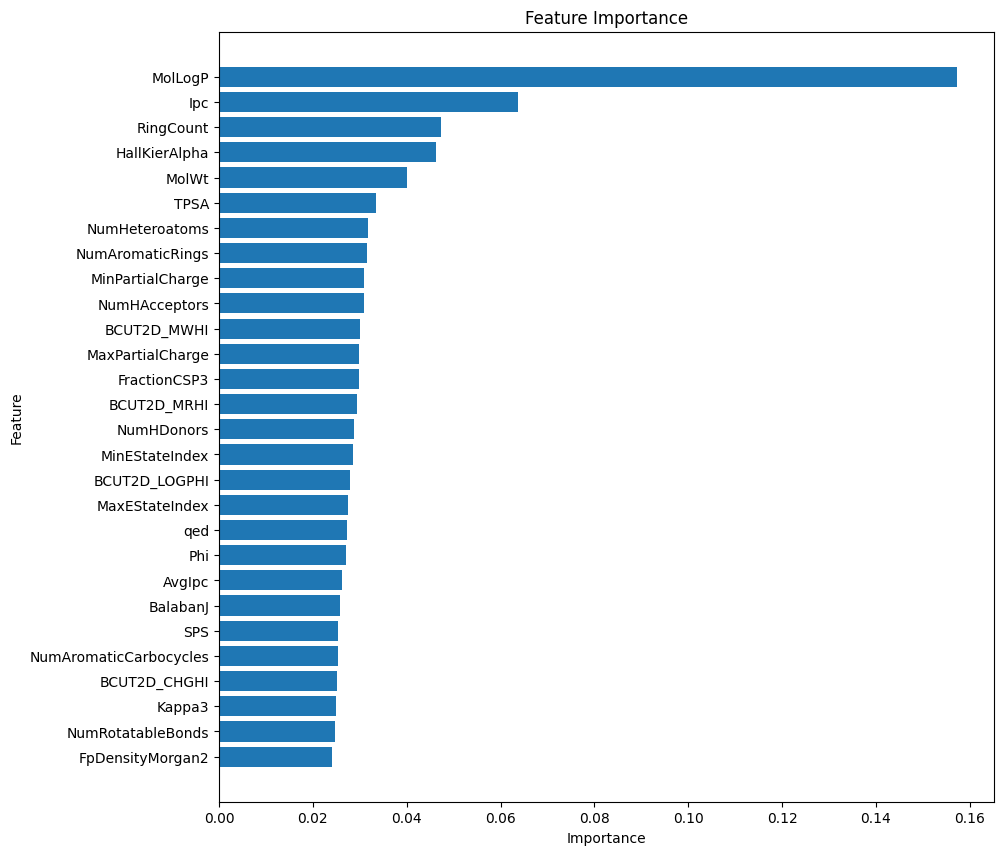


Run complete.


In [10]:
# setup MLflow experiment
EXPERIMENT_NAME = 'xgb_classification_descriptors_grid_search_3_classes_final_feats'
mlflow.set_experiment(EXPERIMENT_NAME)

with mlflow.start_run():
    print("Starting run...")

    # get experiment ID
    experiment_id = mlflow.active_run().info.experiment_id
    print("Experiment ID:", experiment_id)

    # log experiment name
    mlflow.log_param("experiment_name", EXPERIMENT_NAME)

    # extract and log feature names
    features = X_train.columns.tolist()
    mlflow.log_param("feature_names", features)

    # set XGBoost parameters
    model = xgb.XGBClassifier(objective='multi:softprob', num_class=4, use_label_encoder=False, eval_metric='mlogloss')

    # define params for gridsearch
    param_grid = {
        'n_estimators': [200, 500],
        'max_depth': [3, 5, None],
        'learning_rate': [0.01, 0.1],
        'subsample': [0.5, 0.7, 1.0]
    }

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=5,
        n_jobs=-1,
        verbose=2,
        scoring='f1_macro'
    )

    # fit model
    grid_search.fit(X_train, y_train)

    # get best model
    model = grid_search.best_estimator_

    # binarize true labels
    y_train_bin = label_binarize(y_train, classes=[0, 1, 2, 3])
    y_valid_bin = label_binarize(y_valid, classes=[0, 1, 2, 3])

    # get probabilities
    y_train_pred_proba = model.predict_proba(X_train)
    y_valid_pred_proba = model.predict_proba(X_valid)

    # make predictions
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)

    # log model
    mlflow.sklearn.log_model(model, f"{EXPERIMENT_NAME}")

    # calculate metrics
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_auc = roc_auc_score(y_train_bin, y_train_pred_proba, multi_class='ovr', average='macro')
    train_f1 = f1_score(y_train, y_train_pred, average='macro')

    valid_accuracy = accuracy_score(y_valid, y_valid_pred)
    valid_auc = roc_auc_score(y_valid_bin, y_valid_pred_proba, multi_class='ovr', average='macro')
    valid_f1 = f1_score(y_valid, y_valid_pred, average='macro')

    # log metrics
    mlflow.log_metric("train_accuracy", train_accuracy)
    mlflow.log_metric("train_auc", train_auc)
    mlflow.log_metric("train_f1", train_f1)
    mlflow.log_metric("valid_accuracy", valid_accuracy)
    mlflow.log_metric("valid_auc", valid_auc)
    mlflow.log_metric("valid_f1", valid_f1)

    # print metrics
    print("Train Accuracy:", train_accuracy)
    print("Train AUC:", train_auc)
    print("Train F1:", train_f1)
    print("*******************")
    print("Valid Accuracy:", valid_accuracy)
    print("Valid AUC:", valid_auc)
    print("Valid F1:", valid_f1)

    # print confusion matrix
    cm = confusion_matrix(y_valid, y_valid_pred)
    print("\nConfusion Matrix:")
    print(cm)

    # print classification report
    cr = classification_report(y_valid, y_valid_pred)
    print("\nClassification Report:")
    print(cr)

    # log and print best parameters
    best_params = grid_search.best_params_
    for param, value in best_params.items():
        print(f"{param}: {value}")
        mlflow.log_param(param, value)

    # log feature importances
    importances = model.feature_importances_
    for name, importance in zip(features, importances):
        mlflow.log_metric(name, importance)

    # plot feature importances
    importance_df = pd.DataFrame({
        'feature': features,
        'importance': importances})
    importance_df = importance_df.sort_values(by='importance', ascending=True)

    plt.figure(figsize=(10, 10))
    plt.barh(importance_df['feature'], importance_df['importance'])
    plt.title('Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

    print("\nRun complete.")

# Model Comparison

| Model | Train AUC | Validation AUC | Train F1 | Validation F1 |
|---|---|---|---|---|
| Logistic regression | 0.764 | 0.765 | 0.560 | 0.552
| Random forest | **1.000** | **0.927** | **1.000** | **0.803** |
| XGBoost | 1.000 | 0.925 | 0.988 | 0.787 |

# Final Model

Starting run...
Experiment ID: 389268190986064492


2025/05/09 16:45:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Test Accuracy: 0.7969387755102041
Test AUC: 0.9239622027940034
Test F1: 0.8015027821895234

Confusion Matrix:
[[246  35   4]
 [ 45 273  52]
 [  3  60 262]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       285
           1       0.74      0.74      0.74       370
           2       0.82      0.81      0.81       325

    accuracy                           0.80       980
   macro avg       0.80      0.80      0.80       980
weighted avg       0.80      0.80      0.80       980



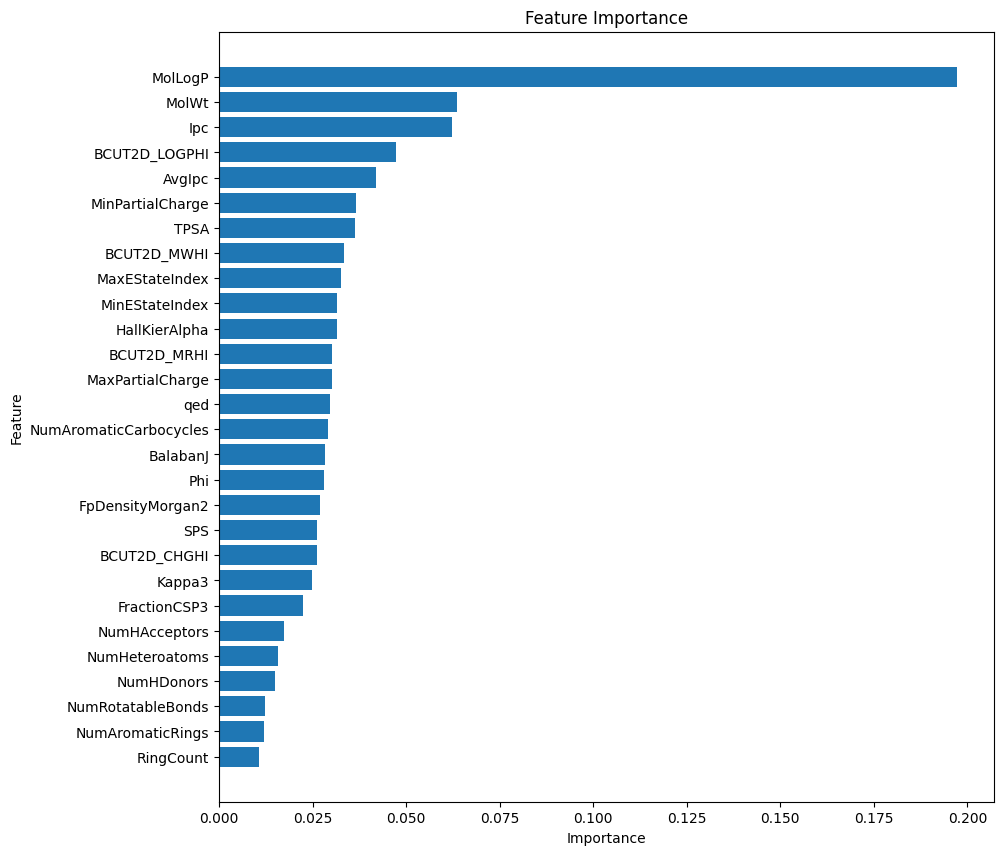

Run complete.


In [11]:
# setup MLflow experiment
EXPERIMENT_NAME = 'rf_final_model'

mlflow.set_experiment(EXPERIMENT_NAME)

with mlflow.start_run():
  print("Starting run...")

  # get experiment ID
  experiment_id = mlflow.active_run().info.experiment_id
  print("Experiment ID:", experiment_id)

  # log experiment name
  mlflow.log_param("experiment_name", EXPERIMENT_NAME)

  # extract and log feature names
  features = X_train.columns.tolist()
  mlflow.log_param("feature_names", features)

  # set random forest parameters
  model = RandomForestClassifier(
      n_estimators=200,
      max_depth=None,
      min_samples_split=2,
      min_samples_leaf=1,
      random_state=7)

  # fit model
  model.fit(X_train, y_train)

  # binarize true labels
  y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

  # get probabilities
  y_test_pred_proba = model.predict_proba(X_test)

  # make predictions
  y_test_pred = model.predict(X_test)

  # log model
  mlflow.sklearn.log_model(model, f"{EXPERIMENT_NAME}")

  # calculate metrics
  test_accuracy = accuracy_score(y_test, y_test_pred)
  test_auc = roc_auc_score(y_test_bin, y_test_pred_proba, multi_class='ovr', average='macro')
  test_f1 = f1_score(y_test, y_test_pred, average='macro')

  # log metrics
  mlflow.log_metric("test_accuracy", test_accuracy)
  mlflow.log_metric("test_auc", test_auc)
  mlflow.log_metric("test_f1", test_f1)


  # print metrics
  print("\nTest Accuracy:", test_accuracy)
  print("Test AUC:", test_auc)
  print("Test F1:", test_f1)

  # print confusion matrix
  cm = confusion_matrix(y_test, y_test_pred)
  print("\nConfusion Matrix:")
  print(cm)

  # print classification report
  cr = classification_report(y_test, y_test_pred)
  print("\nClassification Report:")
  print(cr)

  # log feature importances
  importances = model.feature_importances_
  for name, importance in zip(features, importances):
    mlflow.log_metric(name, importance)

  # plot feature importances
  importance_df = pd.DataFrame({
      'feature': features,
      'importance': importances})
  importance_df = importance_df.sort_values(by='importance', ascending=True)

  plt.figure(figsize=(10, 10))
  plt.barh(importance_df['feature'], importance_df['importance'])
  plt.title('Feature Importance')
  plt.xlabel('Importance')
  plt.ylabel('Feature')
  plt.show()

  print("Run complete.")

# SHAP Explainer

In [7]:
# load saved final model

experiment_name = 'rf_final_model'
client = MlflowClient()

# get experiment ID
experiment = client.get_experiment_by_name(experiment_name)

# get all experiment runs
runs = client.search_runs(experiment.experiment_id)

# get most recent run
run = runs[0]
run_id = run.info.run_id
artif_uri = runs[0].info.artifact_uri

# print info
print("Run ID:", run_id)
print("Artifact URI:", artif_uri)

# load trained model
model_uri = f"runs:/{run_id}/rf_final_model"
model = mlflow.pyfunc.load_model(model_uri)

Run ID: 734d84cd8a874f0aae8c6725e55bd2bd
Artifact URI: file:///content/drive/MyDrive/Solubility/mlruns/389268190986064492/734d84cd8a874f0aae8c6725e55bd2bd/artifacts


In [19]:
# load training data for SHAP explainer
X_train = pd.read_csv('X_train.csv')
X_train.drop(columns=[
    'Drug',
    'NumHeterocycles',
    'NumAtomStereoCenters',
    'NumAmideBonds',
    'NumUnspecifiedAtomStereoCenters',
    'NumBridgeheadAtoms',
    'NumSpiroAtoms'
    ], inplace=True)
X_train.head()

,MaxEStateIndex,MinEStateIndex,qed,SPS,MolWt,MaxPartialCharge,MinPartialCharge,FpDensityMorgan2,BCUT2D_MWHI,BCUT2D_CHGHI,...,FractionCSP3,NumAromaticCarbocycles,NumAromaticRings,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,Phi,RingCount,MolLogP
0,12.305738,-4.339555,0.639989,10.730769,403.398,0.348957,-0.466584,1.692308,32.233361,2.264192,...,0.250000,0.0,2.0,11.0,2.0,14.0,6.0,5.887115,2.0,0.2473
1,11.982723,-3.280078,0.897473,11.500000,297.336,0.413190,-0.452572,2.200000,32.227872,2.147650,...,0.333333,1.0,2.0,5.0,2.0,8.0,4.0,3.934903,2.0,1.9249
2,12.032317,-1.020075,0.495706,46.468750,449.632,0.322469,-0.479930,1.781250,16.366851,2.632062,...,0.923077,0.0,0.0,4.0,4.0,6.0,6.0,6.675438,4.0,3.5941
3,10.286065,-0.741019,0.578647,18.888889,126.155,0.330728,-0.477882,2.333333,16.365789,2.083761,...,0.571429,0.0,0.0,1.0,1.0,2.0,1.0,1.876514,1.0,1.5714
4,10.793168,-1.395692,0.614498,9.625000,227.172,0.342373,-0.492833,1.812500,16.629011,2.233313,...,0.222222,1.0,1.0,5.0,1.0,7.0,4.0,3.288509,1.0,1.3102


In [20]:
#create SHAP explainer
explainer = shap.Explainer(model.predict, X_train)

In [21]:
# save explainer
joblib.dump(explainer, 'explainer.pkl')
print("SHAP explainer saved")

SHAP explainer saved
